# Problem: 

Agriculture in India has been historically influenced by seasonal plantation. This means that farmers generally tend to plant crops according to a set trend i.e wheat ina  certain season, sugarcane in a certain season and so on.

With the rise of organic products, having fresh products all year round is becoming more and more important to consumers. In order to supply these fresh fruits, farmers need to plant crops off-season. These off-season crops are particularly profitable due to their high export value (high value due to demand for organic fruits locally and abroad high off-season). Planting off-season also comes however with associated costs. Increase in pesticides and artifical irrigation proved to be integral for off-season plantation to work.

Source: https://www.sciencedirect.com/science/article/pii/S0306919216300069

In this model we explore whether the associated initial investment for off-season plantation is worth it. We do this by finidng out the casual effect of using a binary variable of 0 for no off-season plantation and 1 for off-season plantation on revenue at the end of the year.

This causal effect will indicate to us the associated increase or decrease in revenue with off-season plantation. 

Price variation of jaggery with time:

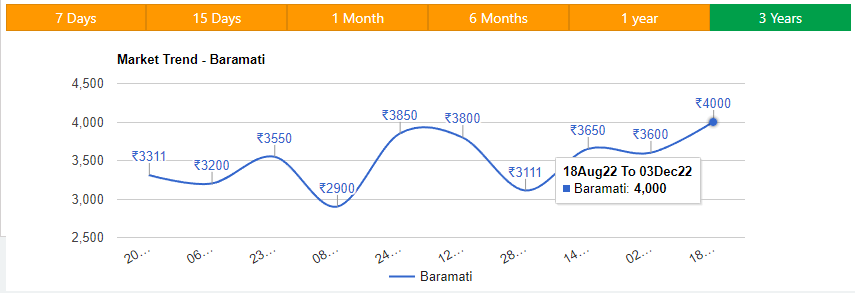

Source: https://www.napanta.com/market-trend/maharashtra/pune/baramati/gur-jaggery/other



# Data:

<table ><tr><th >Feature <th><th> Details<tr><tr>
<tr><td> PrevRevenue <td><td> Revenue generated for sugarcane planted in 2020 November- 2021 April per acre(always planted in-season) <td><tr>
<tr><td> NextRevenue <td><td> Outcome Variable, Revenue generated for sugarcane planted in 2021-2022 season per acre(off-season or in-season) <td><tr>
<tr><td> Off-Season <td><td> Treatment Variable, Indicates whether sugarcane planted in off-season: 1 or not : 0 <td><tr>
<tr><td> Wealth <td><td> Instrument Variable, Indicates whether farmer above 50th percentile of per capita income in Baramati <td><tr>
<tr><td> GlobalTrend <td><td> A global trends towards increasing prices (eg: War): 10-5 or decreasing prices (eg: foreign government incentivizing their farmers) :5-0  <td><tr>
<tr><td> PlantationMonth <td><td> 1-12 indicating month of plantation January - December <td><tr>
<tr><td> AssociatedCost <td><td> Cost as a function of a farmer's available capital<td><tr><table><table>


    
    
Since wealthy farmers are more likely to be able to afford off-season crop plantation and have the knowledge to do so, it is set as the instrument variable. 

    
Outcome variable will indicate change in outcome through measuring and identifying the causal effect. 
Data where the previous and next season are planted in season will show the natural increase/decrease in price and thus act as a control.
    
The associated cost is also an important causal quantity as high initial investments dissuade farmers from investing in off-season plantation despite long term profits. 
 

# Creating Simulated Data

In [2]:
import pandas as pd
import numpy as np
import random

farmers = 1000

#setting of plantation month to determine global trends in sugarcane prices at the moment
month = pd.Series(1)

i=1
while(i<1000):
    rand = random.randint(0,12)
    month.at[month.index[-1]+1]=rand
    i+=1

#setting of trends according to general world prices (price increase due to war in March, slow approach of fulfilling demand in
# August)
trend = pd.Series(2)

j=1
while (j < 1000):
    rand = random.randint(0,2)
    rand2 = random.randint(0,1)
    if (month.at[j]<3):
        if(rand2):
            trend.at[trend.index[-1]+1] = 2+rand 
        else:
            trend.at[trend.index[-1]+1] = 2-rand
        j+=1
        continue
    if (month.at[j]<8):
        if(rand2):
            trend.at[trend.index[-1]+1] = 8+rand
        else:
            trend.at[trend.index[-1]+1] = 8-rand
        j+=1
        continue
    else:
        if(rand2):
            trend.at[trend.index[-1]+1] = 5+rand
        else:
            trend.at[trend.index[-1]+1] = 5-rand
        j+=1
    
#setting on previous 
print(month)
print(trend)

0       1
1      11
2       4
3      10
4       5
       ..
995     5
996     5
997     6
998     1
999     0
Length: 1000, dtype: int64
0       2
1       6
2       8
3       4
4       8
       ..
995    10
996     8
997     8
998     0
999     2
Length: 1000, dtype: int64


Due to lack of data on the exact economic situation in Baramti, we can create simulated data based on the assumption that 3/10 people are farmers and 1/4 people lie below the poverty line. 
Source: https://mahasdb.maharashtra.gov.in/SDB_Reports/Pune/PDF/2010-11_Pune_DSA_8_28.pdf



In [3]:
#setting wealth

wealth = pd.Series(0)

i=1
while (i<farmers):
    rand = random.randint(0,9)
    if(rand<=6):
        wealth.at[wealth.index[-1]+1] = 0
    else:
        wealth.at[wealth.index[-1]+1] = 1
    i+=1
print(wealth)

0      0
1      0
2      1
3      0
4      1
      ..
995    1
996    0
997    0
998    0
999    1
Length: 1000, dtype: int64


According to the above sourced article on off-season plantation, fertilizer cost tend to go up by 56% in the off-season. We can also assume that wealthy farmers have reasonable access to artifical irrigation. Thus we can calculate the increase in costs for both wealthy and poor farmers.

Cost of persticide per acre : 350 INR
Source : http://www.shanlaxjournals.in/pdf/ECO/V1N3/ECO_V1_N3_002.pdf

Assuming around 10% margin of error for increased costs we get an increase of 46-66% in the off-season.

Artifical irrigation costs 50,000 INR as an initial investment. 101952 litres of water are needed to irrigate an inch of an acre. Drip irrigation required 10% of this raw amount. Sugarcane needs on average 20 inches of water. The final amount of water converts to approximately 200,000 litres of water needed for drip irrigation. Assuming a rate of 33 INR per kilo litre, we get a cost of 5940 per year. 

For a poor farmer we can assume an associated cost of Rs 50,000 + 5940 + 350 per year.

For a wealthy farmer we can assume a cost of 6000 + 700 a year (using slightly higher quality products)


In [4]:
#setting associated costs
cost = pd.Series(55000)
i=1
while (i< farmers):
    rand1 = random.randint(0,3000)
    rand2 = random.randint(0,500)
    if(wealth[i]==0):
        cost.at[cost.index[-1]+1] = 55000-rand1 #noise for each farmer depending on government subsidies
    else:
        cost.at[cost.index[-1]+1] = 6700+rand2 #noise for each farmer depending on the quality of products used
    i+=1   
print(cost)    

0      55000
1      54921
2       6984
3      52851
4       6868
       ...  
995     7095
996    53460
997    53589
998    54148
999     6960
Length: 1000, dtype: int64


Profit per acre of sugarcane in season is approximately 50,000-60,000 INR for poor farmers. 
Source: http://www.shanlaxjournals.in/pdf/ECO/V1N3/ECO_V1_N3_002.pdf

Profit per acre of sugarcane in season is approximately 80,000 INR for wealty farmers.

We'll assume noise 5,000 INR for poor farmers and 7,000 INR for rich farmers.

In [5]:
#setting revenue for in season farming

prevrev = pd.Series(55000)

i=1
while (i<farmers):
    rand = random.randint(0,5000)
    rand1 = random.randint(0,7000)
    rand2 = random.randint(0,1)
    if (wealth[i]):
        if(rand2):
            prevrev.at[prevrev.index[-1]+1] =  75000 + rand1 #noise
        else:
            prevrev.at[prevrev.index[-1]+1] = 75000-rand1 #noise
        i+=1
        continue
    else:
        if(rand2):
            prevrev.at[prevrev.index[-1]+1] =  50000 + rand #noise
        else:
            prevrev.at[prevrev.index[-1]+1] =  50000 - rand #noise
        i+=1
print(prevrev)

0      55000
1      53695
2      81537
3      54001
4      68730
       ...  
995    70677
996    47902
997    48379
998    46790
999    77974
Length: 1000, dtype: int64


A majority of wealthy farmers will tend to plant off-season due to the availability of capital and resources. A small minority of farmers will do so when they lack capital. Thus we use a 9/10 in-season for wealthy farmers and a 3/10 for poor farmers.

In [6]:
#setting off-season plantation

off = pd.Series(0)
i=1
while(i<farmers):
    rand1 = random.randint(0,9)
   
    if(wealth[i]==1):
        if(rand1==9):
            off.at[off.index[-1]+1] = 0
        else:
            off.at[off.index[-1]+1] = 1
    else:
        if (rand1<3):
            off.at[off.index[-1]+1] = 1
        else:
            off.at[off.index[-1]+1] = 0
    i+=1
print(off)

0      0
1      1
2      1
3      0
4      1
      ..
995    1
996    0
997    0
998    1
999    1
Length: 1000, dtype: int64


Since we have an approximate that revenue tends to increase by ~50% per acre for off-season planting, we can accordingly calculate the increase in revenue for treated farmers (off-season planters) as a 50% increase in adjusted revenue (adjusted revenue being the revenue adjusted with respect to average increase in prices). Assuming a 8% inflation rate in India, we can adjust prices by 8%

In [7]:
#setting next revenue prices

nextrev = pd.Series(60000)

i=1
while(i<farmers):
    rand1 = random.randint(0,9)
    rand2 = random.randint(0,9)
    rand3 = random.randint(0,1)
    if(trend[i]<=5):
        adjrev = prevrev[i]*(100-rand1)/100
    else:
        adjrev = prevrev[i]*(100+rand1)/100
   
    if(off[i]==1):
        if(trend[i]>6):
            nextrev.at[nextrev.index[-1]+1]=adjrev * (150+rand2)/100
        else:
            nextrev.at[nextrev.index[-1]+1]=adjrev * (150-rand2)/100
    else:
        nextrev.at[nextrev.index[-1]+1]=adjrev
    i+=1

print(nextrev)

0       60000.0000
1       80746.5410
2      133557.6060
3       50760.9400
4      108593.4000
          ...     
995    115019.7498
996     48860.0400
997     48862.7900
998     64897.7300
999    107604.1200
Length: 1000, dtype: float64


In [8]:
#creating the dataset

dict1 = {'PlantationMonth' : month,'AssociatedCost':cost,'PriceTrend':trend,'Wealth':wealth,'PrevRevenue':prevrev,'OffSeason':off
        ,'NextRevenue':nextrev}

df = pd.DataFrame(dict1)

print(df)

     PlantationMonth  AssociatedCost  PriceTrend  Wealth  PrevRevenue  \
0                  1           55000           2       0        55000   
1                 11           54921           6       0        53695   
2                  4            6984           8       1        81537   
3                 10           52851           4       0        54001   
4                  5            6868           8       1        68730   
..               ...             ...         ...     ...          ...   
995                5            7095          10       1        70677   
996                5           53460           8       0        47902   
997                6           53589           8       0        48379   
998                1           54148           0       0        46790   
999                0            6960           2       1        77974   

     OffSeason  NextRevenue  
0            0   60000.0000  
1            1   80746.5410  
2            1  133557.6060  
3  

# Creating the Casual Graph

With the variables now set, we can move on to describing the causal relationships in the graph.

Wealth acts as the instrument variable as possesion of capital will encourage the treatment (planting off-season much more than lacking of capital).

Price Trend acts as a control. We can check to see the effect of untreated samples by refuting the estimate and then figuring out how a placebo treatment would alter the causal estimate.

What we are primarily trying to find out is the conditional expectation of Y (which is the next season's revenue) when treated and untreated. We do this by finding out the difference in Y(1) (treated) - Y(0) untreated while using sufficient adjustment sets for the confounders (in this case the PriceTrend)

E[Y(1)-Y(0)] = Average Treatment Effect 

And finding out the expection over all confounders will give us the Conditional Average Treatment Effect ( CATE )

In [73]:
import graphviz


from IPython.display import Image, display

dot = graphviz.Digraph() 

dot.node('OffSeason', 'OffSeason')  
dot.node('PrevRevenue', 'PrevRevenue')
dot.node('NextRevenue', 'NextRevenue')
dot.node('PlantationMonth', 'PlantationMonth')
dot.node('AssociatedCost','AssociatedCost')
 
dot.node('PriceTrend','PriceTrend')
dot.node('Wealth', 'Wealth')

dot.edge('Wealth','OffSeason')
dot.edge('PrevRevenue','OffSeason')
dot.edge('OffSeason','NextRevenue')
dot.edge('PlantationMonth','OffSeason')
dot.edge('PriceTrend','NextRevenue')
dot.edge('AssociatedCost','OffSeason')
dot.edge('PriceTrend','OffSeason')


print(dot.source)



digraph {
	OffSeason [label=OffSeason]
	PrevRevenue [label=PrevRevenue]
	NextRevenue [label=NextRevenue]
	PlantationMonth [label=PlantationMonth]
	AssociatedCost [label=AssociatedCost]
	PriceTrend [label=PriceTrend]
	Wealth [label=Wealth]
	Wealth -> OffSeason
	PrevRevenue -> OffSeason
	OffSeason -> NextRevenue
	PlantationMonth -> OffSeason
	PriceTrend -> NextRevenue
	AssociatedCost -> OffSeason
	PriceTrend -> OffSeason
}



# Viewing the Model

We can create a causal model using dowhy and fit in the appropriate data

In [2]:
import dowhy


model = dowhy.CausalModel(data=df,
                     graph=dot.source.replace("\n", " "),
                     treatment="OffSeason",
                     outcome="NextRevenue")

NameError: name 'df' is not defined

In [ ]:
model.view_model()

   # Identifying the Estimand
   
   We can see 2 relationships in the data with respect to the treatment

In [77]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                 
────────────(E[NextRevenue|PriceTrend])
d[OffSeason]                           
Estimand assumption 1, Unconfoundedness: If U→{OffSeason} and U→NextRevenue then P(NextRevenue|OffSeason,PriceTrend,U) = P(NextRevenue|OffSeason,PriceTrend)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢                           d                                         ⎛      
E⎢───────────────────────────────────────────────────────(NextRevenue)⋅⎜──────
 ⎣d[PrevRevenue  Wealth  PlantationMonth  AssociatedCost]              ⎝d[Prev

                                                               -1⎤
                     d                                        ⎞  ⎥
─────────────────────────────────────────────────([OffSeason])⎟  ⎥
Revenue  Wealth  PlantationMonth  AssociatedCost]   

# Evaluating the Causal Effect

In [78]:

estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_matching",
                                target_units="att")
print(estimate)

propensity_score_matching


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                 
────────────(E[NextRevenue|PriceTrend])
d[OffSeason]                           
Estimand assumption 1, Unconfoundedness: If U→{OffSeason} and U→NextRevenue then P(NextRevenue|OffSeason,PriceTrend,U) = P(NextRevenue|OffSeason,PriceTrend)

## Realized estimand
b: NextRevenue~OffSeason+PriceTrend
Target units: att

## Estimate
Mean value: 41396.555607240756



We can see that the causal effect has an approximate value of 41,300. 

The meaning of this value is that in general revenue generated by farmers tends to increase by upto 41,300 INR when the crops planted are off-season.

# Refutation

In order to determine whether the model is actually observing a causal effect or simply observing a generic trend that was bound to happen independent of the treatment, we can use a placebo treatment to find out the actual effect of planting off-season

In [79]:

refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=20)
print(refutation)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Refute: Use a Placebo Treatment
Estimated effect:41396.555607240756
New effect:77.72971298434372
p value:0.4960698094969705



We can see here that if treated with a placebo, we get an average increase in revenue of 77.8 which is much lower than the true estimated effect of 41.3 thousand.

This means that our model isn't merely displaying external factors but rather displays true casual effects.

# Counterfactuals

An important part of causal inference is finding out counterfactuals.

For example: Observed data can be a situation wherein a person having a headache, takes a pill and the headache fades i.e Y(1).
A problem comes up i.e what if the person hadn;t taken the pill i.e Y(0). What would the outcome Y(0) be? We can't go back in time and then observe what could have been in observation based experiments. 

Thus DoWhy's gcm helps us generate accurate counterfactuals for certain rows of data.

In [9]:
import networkx as nx, numpy as np, pandas as pd
from dowhy import gcm
import matplotlib.pyplot as plt

We have to create a new graph in networkx and then fit this graph into an invertible structure causal model

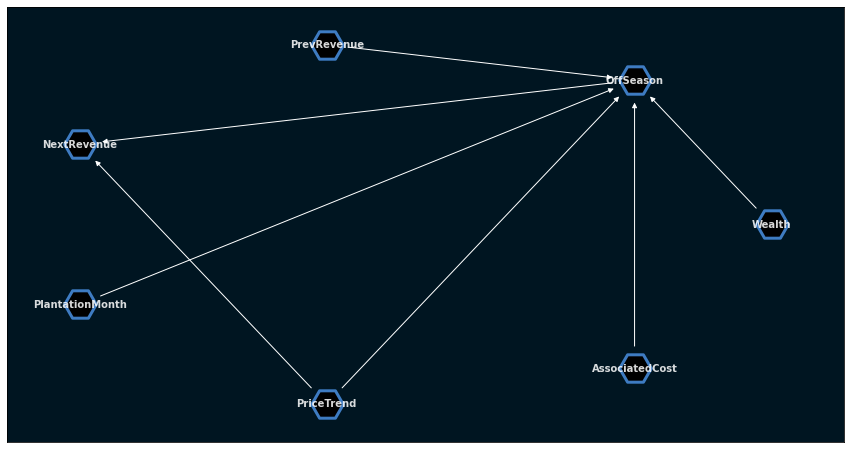

In [10]:
causal_graph = nx.DiGraph([('Wealth','OffSeason')
,('PrevRevenue','OffSeason')
,('OffSeason','NextRevenue')
,('PlantationMonth','OffSeason')
,('PriceTrend','NextRevenue')
,('AssociatedCost','OffSeason')
,('PriceTrend','OffSeason')])

fig = plt.figure(figsize=(15, 8))  # set figsize
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor("#001521")  # set backgrount

pos = nx.drawing.layout.circular_layout(causal_graph)

nx.draw_networkx_nodes(
    causal_graph,
    pos,
    node_shape="H",
    node_size=1000,
    linewidths=3,
    edgecolors="#4a90e2d9",
    node_color=["black"],
)
# add labels
nx.draw_networkx_labels(
    causal_graph,
    pos,
    font_color="#FFFFFFD9",
    font_weight="bold",
    
    font_size=10,
)
# add edges
nx.draw_networkx_edges(
    causal_graph,
    pos,
    edge_color="white",
    node_shape="H",
    node_size=2000,
    
    width=[1],
)

In [11]:
causal_model = gcm.InvertibleStructuralCausalModel(causal_graph) 
gcm.auto.assign_causal_mechanisms(causal_model, df)
gcm.fit(causal_model, df)

Fitting causal mechanism of node AssociatedCost: 100%|███████████████████████████████████| 7/7 [00:00<00:00, 12.69it/s]


This countefactual sample method lets us generate counterfactual examples for rows of data or completely new data based on our news generated causal estimates.

For examples the below predictions of NextRevenue are for Y =NextRevenue and predictions show Y| do(T=1)

In [16]:
pred=gcm.counterfactual_samples(
    causal_model,
    {'Wealth': lambda x: x,'PriceTrend':lambda x:x, 'AssociatedCost': lambda x : x,'PlantationMonth':lambda x:x,
    'PrevRevenue':lambda x :x,'NextRevenue':lambda x : x, 'OffSeason' : lambda x :1},
    observed_data=df)
print(pred)
print(df)

print(df['NextRevenue'].mean()- pred['NextRevenue'].mean(), " is the average difference between them unadjusted")

     AssociatedCost  PriceTrend  PlantationMonth  PrevRevenue  Wealth  \
0             55000           2                1        55000       0   
1             54921           6               11        53695       0   
2              6984           8                4        81537       1   
3             52851           4               10        54001       0   
4              6868           8                5        68730       1   
..              ...         ...              ...          ...     ...   
995            7095          10                5        70677       1   
996           53460           8                5        47902       0   
997           53589           8                6        48379       0   
998           54148           0                1        46790       0   
999            6960           2                0        77974       1   

     OffSeason    NextRevenue  
0            1   98735.802276  
1            1   80746.541000  
2            1  133557.6060

# Scope for Expansion

The associated cost variable can be further expanded by calcluating next profits of treated vs untreated land per acre per year and then figuring out whether the inital investments for them are worth it and figuring out the time required for paying off the investments and getting profit. This time can also be compared by generating counterfactuals as to if they hadn't invested and would be earning their normal revenue in season

We can also implement EconMl's SingleTreeCateInterpreter to visual the Conditional Average Treatment Effect better.